In [1]:
!pip -q install kaggle kagglehub

import kagglehub
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")
print("Downloaded to:", path)


Using Colab cache for faster access to the 'covidqu' dataset.
Downloaded to: /kaggle/input/covidqu


In [2]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 256
EPOCHS = 20
BATCH_SIZE = 8
LR = 1e-4

BASE_DIR = os.path.join(path, "Infection Segmentation Data", "Infection Segmentation Data")

TRAIN_IMG  = os.path.join(BASE_DIR, "Train", "COVID-19", "images")
TRAIN_MASK = os.path.join(BASE_DIR, "Train", "COVID-19", "infection masks")

VAL_IMG  = os.path.join(BASE_DIR, "Val", "COVID-19", "images")
VAL_MASK = os.path.join(BASE_DIR, "Val", "COVID-19", "infection masks")

TEST_IMG  = os.path.join(BASE_DIR, "Test", "COVID-19", "images")
TEST_MASK = os.path.join(BASE_DIR, "Test", "COVID-19", "infection masks")

print("BASE_DIR:", BASE_DIR)
print("TRAIN_IMG exists:", os.path.exists(TRAIN_IMG))
print("VAL_IMG exists:", os.path.exists(VAL_IMG))
print("TEST_IMG exists:", os.path.exists(TEST_IMG))
print("TF:", tf.__version__)
print("GPU:", len(tf.config.list_physical_devices("GPU")) > 0)


BASE_DIR: /kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data
TRAIN_IMG exists: True
VAL_IMG exists: True
TEST_IMG exists: True
TF: 2.19.0
GPU: True


In [3]:
def load_data(image_dir, mask_dir, img_size=256):
    images, masks = [], []
    filenames = sorted(os.listdir(image_dir))

    for fname in filenames:
        img_path  = os.path.join(image_dir, fname)
        mask_path = os.path.join(mask_dir, fname)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (img_size, img_size)).astype(np.float32) / 255.0
        mask = cv2.resize(mask, (img_size, img_size)).astype(np.float32) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        images.append(img)
        masks.append(mask)

    images = np.array(images)[..., np.newaxis]
    masks  = np.array(masks)[..., np.newaxis]
    return images, masks

X_train, y_train = load_data(TRAIN_IMG, TRAIN_MASK, IMG_SIZE)
X_val, y_val     = load_data(VAL_IMG, VAL_MASK, IMG_SIZE)
X_test, y_test   = load_data(TEST_IMG, TEST_MASK, IMG_SIZE)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)


Train: (1864, 256, 256, 1) (1864, 256, 256, 1)
Val: (466, 256, 256, 1) (466, 256, 256, 1)
Test: (583, 256, 256, 1) (583, 256, 256, 1)


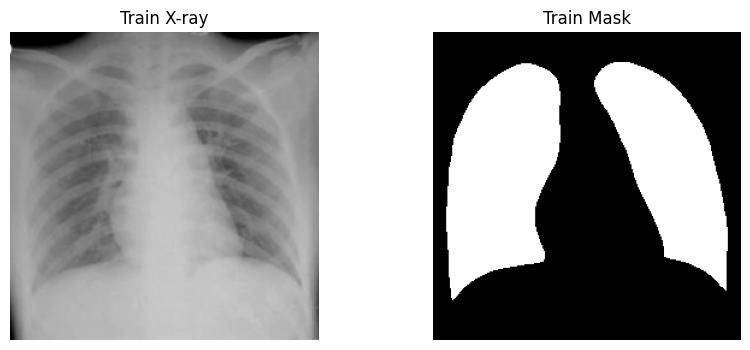

In [4]:
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Train X-ray")
plt.imshow(X_train[idx].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Train Mask")
plt.imshow(y_train[idx].squeeze(), cmap="gray")
plt.axis("off")

plt.show()


In [5]:
def unet(input_shape=(256,256,1)):
    inputs = Input(input_shape)

    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    u4 = UpSampling2D()(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)
    return Model(inputs, outputs)

model = unet((IMG_SIZE, IMG_SIZE, 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
rmse_metric = tf.keras.metrics.RootMeanSquaredError(name="rmse")

model.compile(
    optimizer=Adam(LR),
    loss="binary_crossentropy",
    metrics=[rmse_metric]
)

print("Compiled with metrics:", model.metrics_names)


Compiled with metrics: ['loss', 'compile_metrics']


In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 107s 335ms/step - loss: 0.4474 - rmse: 0.3752 - val_loss: 0.3352 - val_rmse: 0.3243
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 287ms/step - loss: 0.3295 - rmse: 0.3203 - val_loss: 0.3130 - val_rmse: 0.3139
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 288ms/step - loss: 0.3131 - rmse: 0.3126 - val_loss: 0.2752 - val_rmse: 0.2953
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 288ms/step - loss: 0.2810 - rmse: 0.2974 - val_loss: 0.2623 - val_rmse: 0.2888
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 68s 290ms/step - loss: 0.2703 - rmse: 0.2925 - val_loss: 0.2528 - val_rmse: 0.2833
Epoch 6/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 289ms/step - loss: 0.2569 - rmse: 0.2850 - val_loss: 0.2349 - val_rmse: 0.2736
Epoch 7/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 290ms/step - loss: 0.2478 - rmse: 0.2800 - val_loss: 0.2243 - val_rmse: 0.2673
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 289ms/step - loss: 0.2330 - rmse: 0.2714 - val_loss: 0.2201 - val_rmse: 0.2652
Epoch 9/20
233/

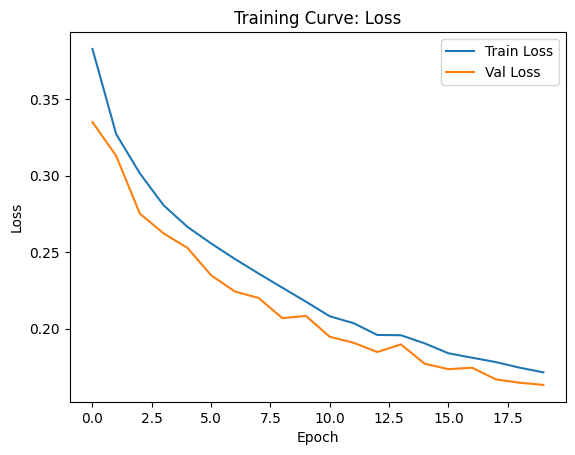

In [15]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training Curve: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


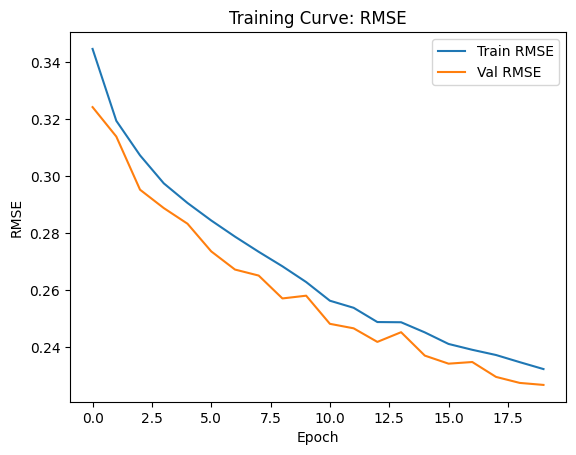

In [16]:
plt.figure()
plt.plot(history.history["rmse"], label="Train RMSE")
plt.plot(history.history["val_rmse"], label="Val RMSE")
plt.title("Training Curve: RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [9]:
test_loss, test_rmse = model.evaluate(X_test, y_test, verbose=0)
print(f"TEST Loss: {test_loss:.4f}")
print(f"TEST RMSE: {test_rmse:.4f}")


TEST Loss: 0.1665
TEST RMSE: 0.2288


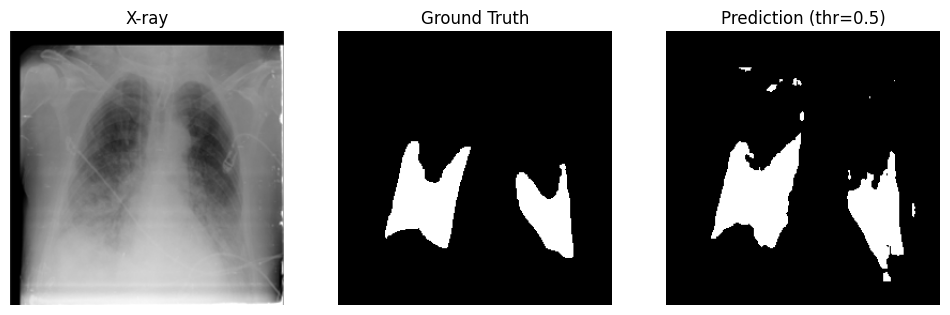

In [10]:
idx = np.random.randint(0, len(X_test))
pred = model.predict(X_test[idx:idx+1], verbose=0)[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("X-ray")
plt.imshow(X_test[idx].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(y_test[idx].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction (thr=0.5)")
plt.imshow((pred.squeeze() > 0.5), cmap="gray")
plt.axis("off")

plt.show()


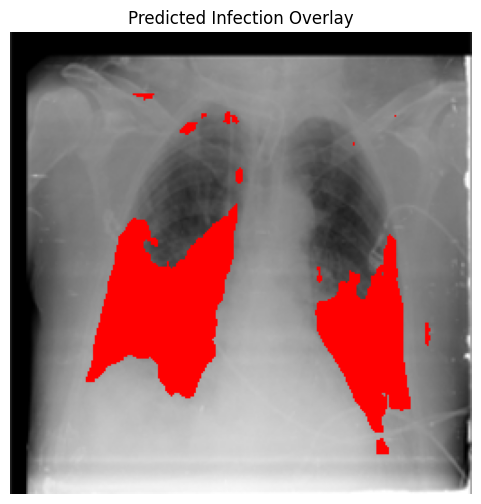

In [17]:
img = X_test[idx].squeeze()
mask_pred = (pred.squeeze() > 0.5)

overlay = np.stack([img, img, img], axis=-1)
overlay = overlay.copy()
overlay[mask_pred] = [1.0, 0.0, 0.0]

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Predicted Infection Overlay")
plt.axis("off")
plt.show()
